In [1]:
import numpy as np
from scipy.signal import convolve,decimate,resample
from scipy.io import wavfile

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (28, 6)

In [3]:
fs=192000 # sampling rate original
fs2=96000 # samplig rate de los audios almacenados solo 192k 96k y 48k
downs=int(fs/fs2) # 1,2,4

In [4]:
rpath = "./Filtros/"
apath = "./Audios/"

In [5]:
def sigmoid(x,x0=0,a=1):
    x1 = 2*(x-x0)/a
    sig = np.where(x1 < 0, np.exp(x1)/(1 + np.exp(x1)), 1/(1 + np.exp(-x1)))
    return sig

In [6]:
def fadeinout(data, fadein=0.05, fadeout=None, fs=48000):
    if fadein is not None:
        nin = int(fadein*fs)
        a = (1.0-np.cos(np.linspace(0,np.pi,nin)))/2.0 
        if data.ndim == 2:
            for n in range(data.shape[1]):
                data[:nin,n]  *= a
        else:
            data[:nin] *= a
    if fadeout is not None:
        nout = int(fadeout*fs)
        a = (1.0+np.cos(np.linspace(0,np.pi,nout)))/2.0 
        if data.ndim == 2:
            for n in range(data.shape[1]):
                data[-nout:,n]  *= a
        else:
            data[-nout:] *= a        
    return
    

In [7]:
def whitenoise(T, flow=None, fhigh=None, fslow=None, fshigh=None, nchannels=1, fadein=None, fadeout=None, fs=48000, filename="wnoise"):
    """
    Genera ruido blanco de duracion T limitado en banda entre flow y fhigh (fslow y fshigh dan las pendientes de
    la sigmoidea del limite de banda) puede generar nchannels canales
    """
    nsamples = int(fs*T)
    freqs = np.fft.rfftfreq(nsamples, 1/fs)
    freqs[0] = 1/nsamples
    fmax = freqs[-1]
    if flow is not None:
        if fslow is None:
            fslow=flow
        s1 = sigmoid(freqs/fmax,flow/fmax,fslow/fmax)
    else:
        s1 = 1
    if fhigh is not None:
        if fshigh is None:
            fshigh=fhigh/4.0
        s2 = sigmoid(freqs/fmax,fhigh/fmax,-fshigh/fmax)
    else:
        s2 = 1
    real = s1*s2*np.random.randn(nchannels, freqs.shape[0])
    imag = s1*s2*np.random.randn(nchannels, freqs.shape[0])
    if not nsamples & 1:
        imag[-1] = 0.
    wnoise = np.array(np.fft.irfft(real + 1j*imag),ndmin=2, dtype='float64').T
    wnoise /= np.abs(wnoise).max(axis=0)
    fadeinout(wnoise, fadein=fadein, fadeout=fadeout, fs=fs)
    wavfile.write(filename + '.wav',fs,wnoise) 
    return wnoise

# Aca empieza la generacion de estimulos

In [8]:
ri_f2 = np.load(rpath + 'ri_f2.npy')

In [9]:
ri_f2.shape

(1024, 10)

In [10]:
parlantes = ['P1','P3','P4','P5']
rms = ['13']
npar = [0,2,3,4]
nparlantes = len(parlantes)
nrms = len(rms)

In [11]:
# generamos banda de ruido desde 40 Hz a 20 kHz


In [12]:
dur = 0.5
wn = whitenoise(dur, flow=40, fhigh=20000, nchannels=1, fadein=0.05, fadeout=0.05, fs=fs,filename=apath+"wnoise")
wn = wn*0.1
rms_wn = 10*np.log10(np.mean(np.square(wn)))
print(rms_wn)

-32.73728828221727


/var/folders/nl/515l3mns2537252cccqsxvl40000gn/T/ipykernel_10378/3653316971.py:3: RuntimeWarning: overflow encountered in exp
  sig = np.where(x1 < 0, np.exp(x1)/(1 + np.exp(x1)), 1/(1 + np.exp(-x1)))
/var/folders/nl/515l3mns2537252cccqsxvl40000gn/T/ipykernel_10378/3653316971.py:3: RuntimeWarning: invalid value encountered in true_divide
  sig = np.where(x1 < 0, np.exp(x1)/(1 + np.exp(x1)), 1/(1 + np.exp(-x1)))


In [13]:
nsamples = int(np.floor(dur*fs))
df = fs/nsamples
fn = np.arange(nsamples)*df

In [14]:
nsamples2 = int((fs*dur-1023)/downs)+1
wnn = np.zeros((nsamples2,nparlantes))
max_wn = np.zeros((nparlantes,))
mean_wn = np.zeros((nparlantes,))
for n in range(nparlantes):
    temp = convolve(wn[:,0],ri_f2[:,npar[n]], mode='valid')
    if (fs2 < fs):
        wnn[:,n] =  decimate(temp,int(fs/fs2))
    else:
        wnn[:,n] = temp
    max_wn[n] = max(np.abs(wnn[:,n]))
    mean_wn[n] = np.mean(np.abs(wnn[:,n]))

crest = max(max_wn/mean_wn)

for n in range(nparlantes):
    wnn[:,n] = wnn[:,n] / (crest*mean_wn[n]) 
    max_wn[n] = max(np.abs(wnn[:,n]))
    mean_wn[n] = np.mean(np.abs(wnn[:,n]))  
    wavfile.write(apath + "wnoise_" + str(n+1) + '_' + parlantes[n] + '.wav',fs2,wnn[:,n]) 

In [46]:
int((fs*dur-1023)/2)

287488

In [15]:
fs2, data = wavfile.read(apath + "enmascarante.wav")

In [16]:
fs2

96000

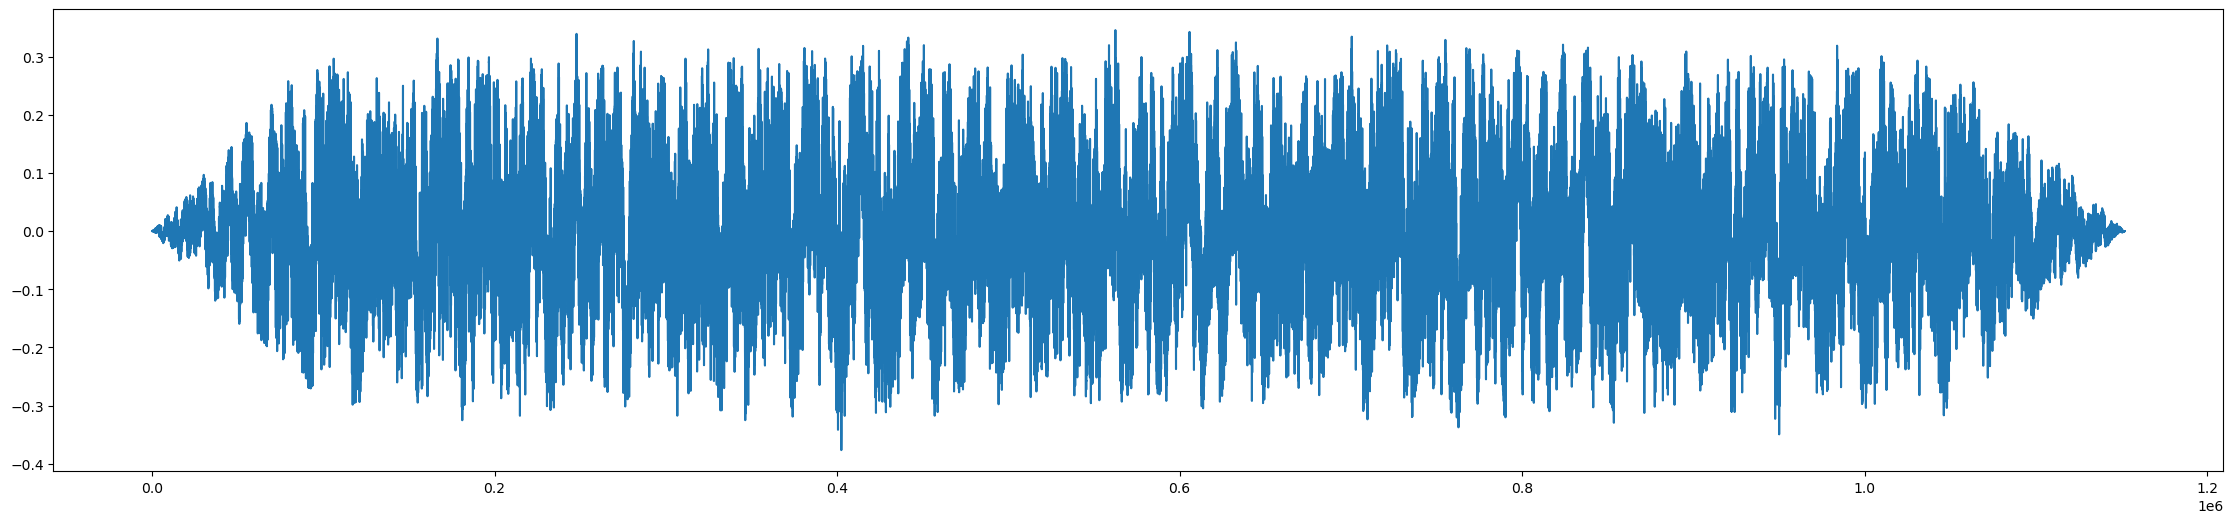

In [17]:
plt.plot(data)

In [20]:
data.shape[0]/fs2

12.0

In [30]:
data_resampled = resample(data[:,0],int(data.shape[0]*96000/44100));

In [31]:
data_resampled.shape[0]/96000

12.0

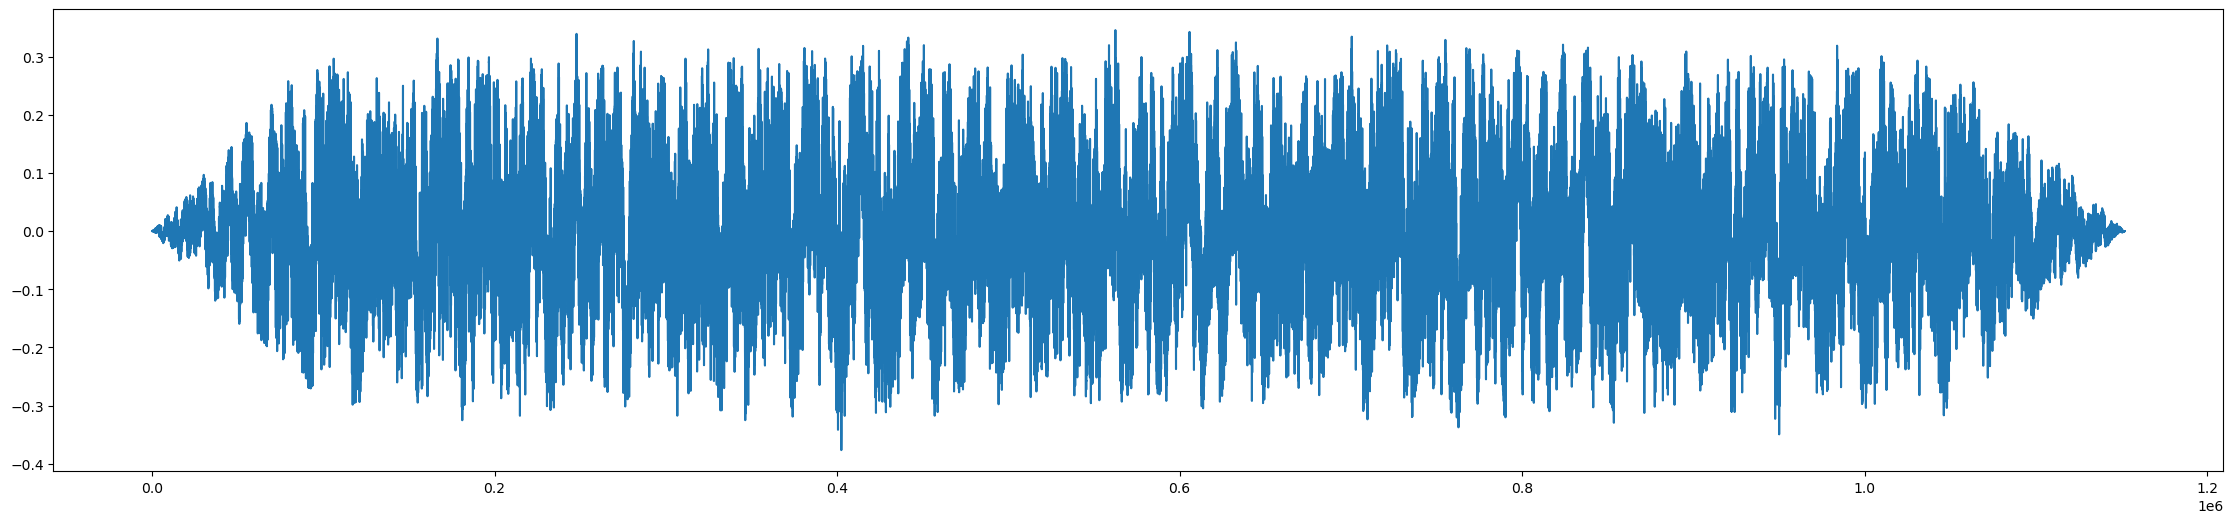

In [32]:
plt.plot(data_resampled)

In [33]:
wavfile.write(apath+"enmascarante.wav",96000,data_resampled)